In [1]:
import xarray as xr
import pandas as pd
import fsspec
import dask

dask.config.set({"distributed.logging.distributed": "critical"})

In [2]:
# from dask.distributed import Client
# setup a local dask cluster
# client = Client()
# client

from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 4
options.worker_memory = 16
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=1, maximum=40)
cluster


In [3]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-us-central1-b-prod-dask-gateway.prod:80/prod.c51c261d620f453fbebbe4f47b30dadf Dashboard: https://hub.carbonplan.org/services/dask-gateway/clusters/prod.c51c261d620f453fbebbe4f47b30dadf/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
bucket = "gs://carbonplan-data/raw/terraclimate/4000m/raster.zarr"
mapper = fsspec.get_mapper(bucket)

In [7]:
%%time
ds = xr.open_zarr(mapper, consolidated=True)

CPU times: user 92.9 ms, sys: 4.6 ms, total: 97.5 ms
Wall time: 393 ms


In [9]:
ds

,Array,Chunk
Bytes,111.08 GB,99.53 MB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,111.08 GB,99.53 MB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
ds.dims

Frozen(SortedKeysDict({'time': 744, 'lat': 4320, 'lon': 8640, 'crs': 1}))

In [11]:
null_count = ds.isnull().mean('time')
null_count = null_count.where(null_count != 1)

In [13]:
pdsi = null_count.pdsi.load()

# [::50, ::50].plot()

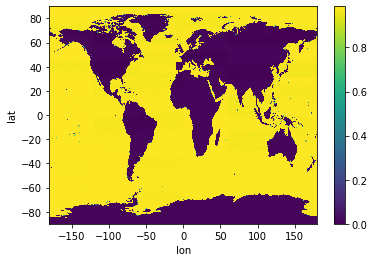

In [14]:
pdsi.coarsen(lat=2, lon=2).mean().plot(robust=True)
# pdsi

In [7]:
df = pd.read_csv('FIA_forBill_DroughtRiskV1_08182020.csv')  #.iloc[0:10000]
df.head()

,lat,lon,n_condprops,yr1,yr2,yr3,y4,BA1,BA2,BA3,...,BAM1,BAM2,BAM3,BAM4,fieldcd,dist_insect,dist_fire,age,Treatment,dist_human
0,-14.359,-170.75,1,2001,2012.0,NaN,NaN,22.503,21.8450,NaN,...,0.0,0.0,NaN,NaN,989.0,0,0,25.000,1,0
1,-14.345,-170.72,2,2001,2012.0,NaN,NaN,18.493,11.8680,NaN,...,0.0,0.0,NaN,NaN,989.0,0,0,15.000,1,0
2,-14.332,-170.82,2,2001,2012.0,NaN,NaN,14.790,24.0030,NaN,...,0.0,0.0,NaN,NaN,987.0,0,0,30.000,1,0
3,-14.321,-170.77,1,2001,2012.0,NaN,NaN,24.197,8.7523,NaN,...,0.0,0.0,NaN,NaN,989.0,0,0,38.667,1,0
4,-14.320,-170.70,2,2001,2012.0,NaN,NaN,36.604,40.0730,NaN,...,0.0,0.0,NaN,NaN,989.0,0,0,30.000,0,0


In [9]:
import math

n = 5

size = math.ceil(len(df) / n)
assert len(df) <= size*n
print(size)

32363


In [10]:
index_ds = df[['lat', 'lon']].to_xarray()
index_ds

<xarray.Dataset>
Dimensions:  (index: 161815)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 ... 161810 161811 161812 161813 161814
Data variables:
    lat      (index) float64 -14.36 -14.35 -14.33 -14.32 ... 61.44 61.46 61.47
    lon      (index) float64 -170.8 -170.7 -170.8 ... -145.1 -144.4 -144.5

In [11]:
# %%time
# ds_cond = ds.sel(lat=index_ds['lat'], lon=index_ds['lon'], method='nearest')
# ds_cond

In [12]:
from tqdm import tqdm

In [13]:
ds_list = []
for k, ids in tqdm(index_ds.groupby(index_ds.index // size)):
    ds_list.append(ds.sel(lat=ids['lat'], lon=ids['lon'], method='nearest'))

100%|██████████| 5/5 [16:16<00:00, 195.27s/it]


In [13]:
# ds_list[:2]

In [14]:
sum(d.nbytes for d in ds_list) / 1e9

4.81952773

In [15]:
parts = []
for d in tqdm(ds_list):
    part = d.compute()
    parts.append(part)

100%|██████████| 5/5 [10:37<00:00, 127.44s/it]


In [16]:
ds_cond = xr.concat(parts, dim='index')
# ds_cond = ds_cond.chunk({'index': 40000, 'time': 240})

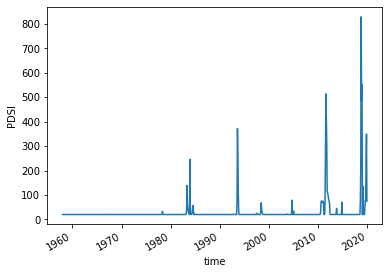

In [17]:
ds_cond.PDSI.isnull().sum('index').plot()

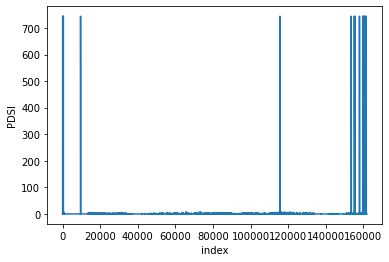

In [18]:
ds_cond = xr.concat(parts, dim='index')
ds_cond = ds_cond.chunk({'index': 40000, 'time': 240})

In [19]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:37371 Dashboard: /user/jhamman/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 53.69 GB


In [20]:
bucket = "gs://carbonplan-scratch/terraclimate-fia-cond.zarr"
mapper2 = fsspec.get_mapper(bucket)

ds_cond.to_zarr(mapper2, mode='w')

In [2]:
# bucket = "gs://carbonplan-scratch/terraclimate-fia-cond.zarr"
# mapper2 = fsspec.get_mapper(bucket)

# ds_cond = xr.open_zarr(mapper2)

In [ ]:
# ds_cond_ann = ds_cond.resample(time='AS').mean()
# ds_cond_ann

In [21]:
def weighted_mean(ds, *args, **kwargs):
    weights = ds.time.dt.days_in_month
    return ds.weighted(weights).mean(dim='time')

ds_cond_ann = ds_cond.resample(time='AS').map(weighted_mean, dim='time')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


In [22]:
ds_cond_ann = ds_cond_ann.chunk({'index': -1, 'time': -1})
ds_cond_ann['lon'] = ds_cond_ann['lon'].load()
ds_cond_ann['lat'] = ds_cond_ann['lat'].load()
ds_cond_ann

<xarray.Dataset>
Dimensions:                 (index: 161815, time: 62)
Coordinates:
  * time                    (time) datetime64[ns] 1958-01-01 ... 2019-01-01
    lat                     (index) float64 -14.35 -14.35 -14.31 ... 61.44 61.48
    lon                     (index) float64 -170.8 -170.7 ... -144.4 -144.5
  * index                   (index) int64 0 1 2 3 ... 161812 161813 161814
Data variables:
    PDSI                    (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    aet                     (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    pet                     (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    ppt                     (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    ppt_station_influence   (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    tmax                    (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    tmax_station_influence  (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    tmin                    (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    tmin_station_influence  (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>
    vpd                     (time, index) float64 dask.array<chunksize=(62, 161815), meta=np.ndarray>

In [23]:
# from zarr.storage import ZipStore

# store = ZipStore('terraclimate-fia-cond-ann.zarr.zip', mode='w')


In [24]:
encoding = {k: {} for k in ds_cond_ann.data_vars}
encoding

{'PDSI': {},
 'aet': {},
 'pet': {},
 'ppt': {},
 'ppt_station_influence': {},
 'tmax': {},
 'tmax_station_influence': {},
 'tmin': {},
 'tmin_station_influence': {},
 'vpd': {}}

In [25]:
bucket = "gs://carbonplan-scratch/terraclimate-fia-cond-ann-3.zarr"
mapper3 = fsspec.get_mapper(bucket, create=True)

from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_cond_ann.to_zarr(mapper3, mode='w', consolidated=True, encoding=encoding)

In [26]:
da = ds_cond_ann.PDSI.load()

In [27]:
da.isel(index=slice(20000))

<xarray.DataArray 'PDSI' (time: 62, index: 20000)>
array([[-0.01013654, -0.03561608, -0.09917767, ...,  0.46000044,
         0.71561675, -0.57397241],
       [ 0.19150698,  0.19150714,  0.27616499, ...,  1.50630166,
         0.45178121, -0.98493087],
       [ 1.54125731,  1.57459045,  1.66612038, ...,  1.64617543,
         0.92541022,  0.83961784],
       ...,
       [ 3.25150717,  3.36027439,  3.32630182, ..., -1.85999962,
        -1.05424604, -0.57095843],
       [ 4.11095935,  4.14438398,  4.1109592 , ..., -0.54986279,
         0.62739739,  1.47863046],
       [ 3.44137024,  3.42438387,  3.48301407, ...,  1.7736992 ,
         2.99260306,  1.84958947]])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1959-01-01 ... 2019-01-01
    lat      (index) float64 -14.35 -14.35 -14.31 -14.31 ... 32.15 32.19 32.19
    lon      (index) float64 -170.8 -170.7 -170.8 -170.8 ... -82.35 -88.1 -86.52
  * index    (index) int64 0 1 2 3 4 5 6 ... 19994 19995 19996 19997 19998 19999

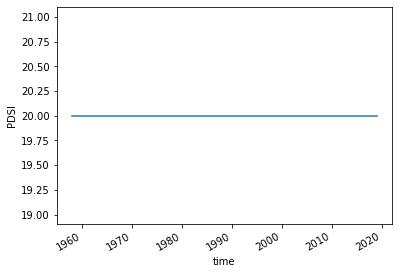

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - Timed out trying to connect to 'tcp://127.0.0.1:37371' after 10 s: Timed out trying to connect to 'tcp://127.0.0.1:37371' after 10 s: in <distributed.comm.tcp.TCPConnector object at 0x7f42203310d0>: ConnectionRefusedError: [Errno 111] Connection refused
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/comm/tcp.py", line 184, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook

In [31]:
da.isnull().sum('index').plot()